# レスラー方程式(ランダムなシフト付きsin外力のある状態)

レスラー方程式の外力のある場合に関して，$\sin$ 波に位相のランダムなシフトがある場合を考える．

In [1]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os

rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time


CPU times: user 1 µs, sys: 3 µs, total: 4 µs
Wall time: 9.3 µs


In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


mu = 0.01
A = 0.1
initial_state = [1.0, 0.0]  # Initial states for [X, Y, x_lorenz, y_lorenz, z_lorenz]

# 時間の設定
t_span = [0, 10000]  # 開始時刻と終了時刻
t_eval = np.linspace(t_span[0], t_span[1], 100000)  # 評価する時間点

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
import random

# P_shifted の計算
period = np.floor(1.05*t_eval / (4*2*np.pi))

# Function to calculate random phase shift (modified to also return the phase shift values)
def calculate_random_phase_shift_and_phase_values(t_eval):
    period = np.floor(1.05 * t_eval / (4 * 2 * np.pi))
    random_phase_shift = np.zeros_like(t_eval)
    phase_values = np.zeros_like(t_eval)
    current_shift = 0

    for i in range(1, len(t_eval)):
        if period[i] != period[i-1]:  # Detect a change in period
            current_shift = current_shift + random.uniform(-12, 12)  # Random shift between -12 and 12. Shift accumulates.
        phase_shift = 1.05 * t_eval[i] + (current_shift / 24) * 2 * np.pi 
        random_phase_shift[i] = A * np.sin(phase_shift)
        phase_values[i] = phase_shift

    return random_phase_shift, phase_values

# Calculate P_shifted_random and phase_values
P_shifted_random, phase_values = calculate_random_phase_shift_and_phase_values(t_eval)


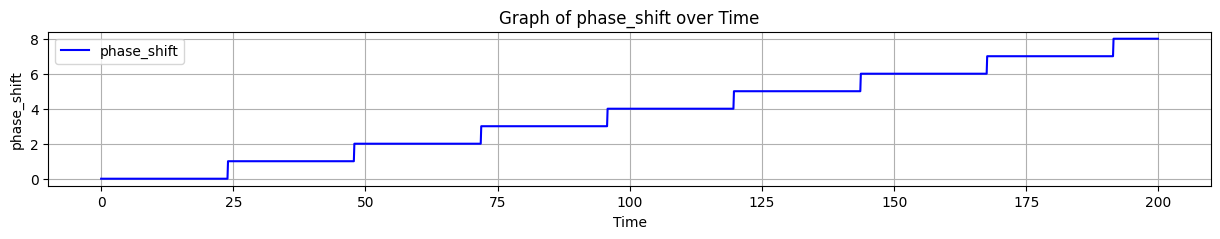

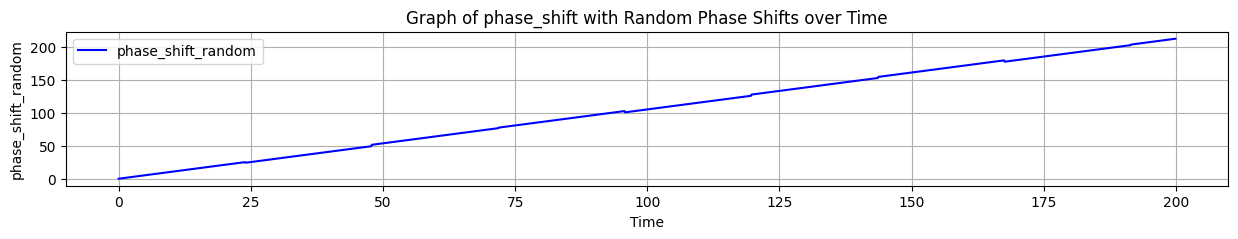

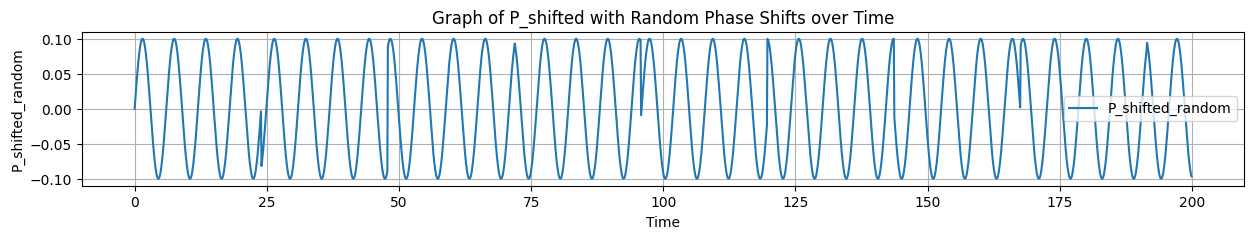

In [4]:
sample = 2000
# period のグラフを描画
plt.figure(figsize=(15, 2))
plt.plot(t_eval[:sample], period[:sample], label='phase_shift', color='blue')
plt.title('Graph of phase_shift over Time')
plt.xlabel('Time')
plt.ylabel('phase_shift')
plt.legend()
plt.grid(True)

plt.show()


# Plot phase_shift with random phase shifts
plt.figure(figsize=(15, 2))
plt.plot(t_eval[:sample], phase_values[:sample], label='phase_shift_random', color='blue')
plt.title('Graph of phase_shift with Random Phase Shifts over Time')
plt.xlabel('Time')
plt.ylabel('phase_shift_random')
plt.legend()
plt.grid(True)
plt.show()

# Plot P_shifted with random phase shifts
plt.figure(figsize=(15, 2))
plt.plot(t_eval[:sample], P_shifted_random[:sample], label='P_shifted_random')
plt.title('Graph of P_shifted with Random Phase Shifts over Time')
plt.xlabel('Time')
plt.ylabel('P_shifted_random')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# t_eval と P_shifted を組み合わせて二次元配列を作成
P_shifted_combined = np.vstack((t_eval, P_shifted_random))

# 配列の形状を確認（オプション）
print(P_shifted_combined)

[[0.00000000e+00 1.00001000e-01 2.00002000e-01 ... 9.99980000e+03
  9.99990000e+03 1.00000000e+04]
 [0.00000000e+00 1.04808213e-02 2.08461954e-02 ... 4.10217642e-02
  3.12374552e-02 2.11090627e-02]]


In [6]:
def find_P_shift(t_eval, t):
    idx = np.searchsorted(t_eval, t)
    if idx > 0 and (idx == len(t_eval) or np.abs(t - t_eval[idx-1]) < np.abs(t - t_eval[idx])):
        idx = idx - 1
    return idx


In [7]:
# 微分方程式の定義（P_shifted を直接使用）
def coupled_system(t, state, mu, A):
    X, Y = state
    # t_eval と一致する t のインデックスを見つける

    dXdt = Y
    dYdt = mu * (1 - X**2) * Y - X + P_shifted_random[find_P_shift(t_eval, t)]
    
    return [dXdt, dYdt]

# 微分方程式を解く
sol = solve_ivp(coupled_system, t_span, initial_state, args=(mu, A), t_eval=t_eval)


In [8]:
import pandas as pd

# DataFrameの作成
data_frame_with_shifted_force = pd.DataFrame({
    'time': sol.t,
    'x': sol.y[0],
    'y': sol.y[1],
    'P_shifted': [P_shifted_random[find_P_shift(t_eval, t)] for t in sol.t]  # 位相シフトされた外力P(t)の列を追加
})


In [9]:
dir_name = f"data"
os.makedirs(dir_name, exist_ok=True)

filename_with_force = f"{dir_name}/VDP_random.csv"

# CSVファイルにデータを保存
data_frame_with_shifted_force.to_csv(filename_with_force, index=False)

# CSVファイルを読み込む
data_loaded_with_force = pd.read_csv(filename_with_force)

# CSVから値を抽出してNumpy配列に格納
X = data_loaded_with_force[['x', 'y', 'P_shifted']].values


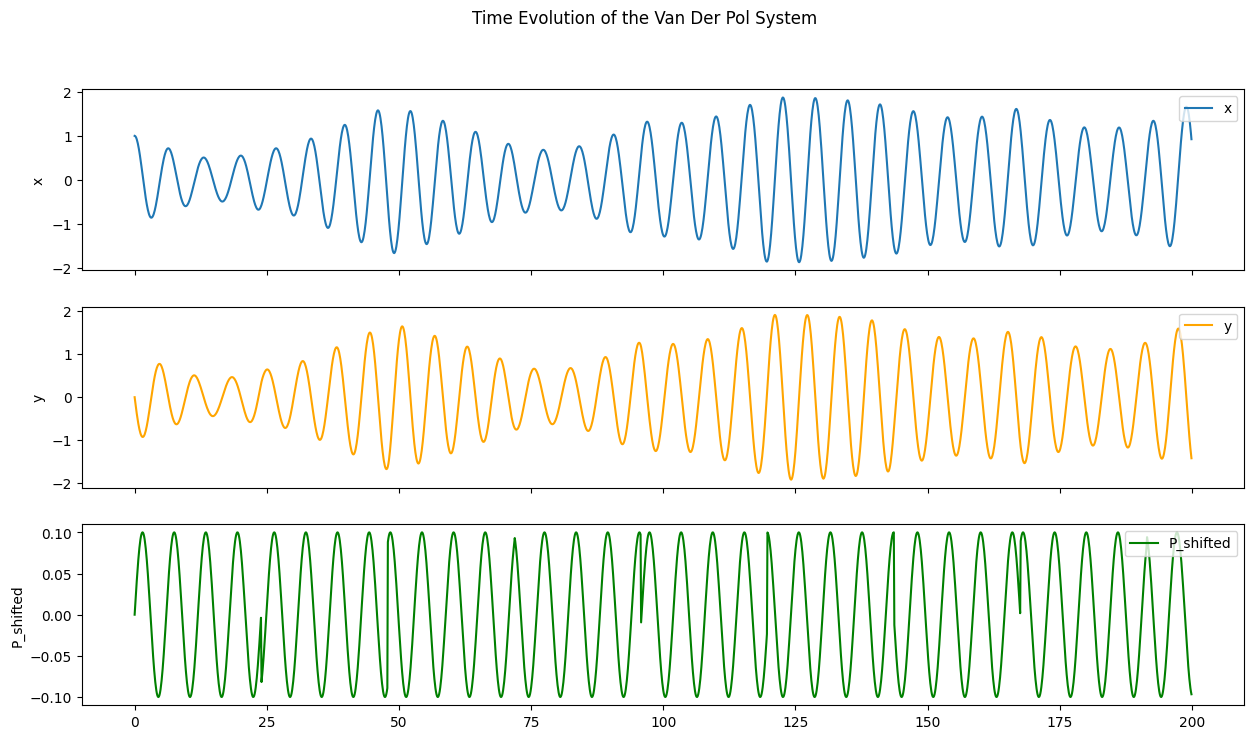

In [10]:
sample = 0
plot_length = 2000

# 時間ごとのx, y, zそれぞれのグラフ
fig, axs = plt.subplots(3, 1, figsize=(15, 8), sharex=True)
axs[0].plot(data_loaded_with_force['time'][sample: sample+plot_length], data_loaded_with_force['x'][sample: sample+plot_length], label='x')
axs[0].set_ylabel('x')
axs[0].legend(loc='upper right')

axs[1].plot(data_loaded_with_force['time'][sample: sample+plot_length], data_loaded_with_force['y'][sample: sample+plot_length], label='y', color='orange')
axs[1].set_ylabel('y')
axs[1].legend(loc='upper right')

# Plot P_shifted vs. time
axs[2].plot(data_loaded_with_force['time'][sample: sample+plot_length], data_loaded_with_force['P_shifted'][sample: sample+plot_length], label='P_shifted', color='green')
axs[2].set_ylabel('P_shifted')
axs[2].legend(loc='upper right')

plt.suptitle('Time Evolution of the Van Der Pol System')
plt.show()